# Chapter: Input-Output Modeling - Part 1: 


## Topic: Industrial Fired Heater Modeling via ARX model

In [1]:
# import packages 
import matplotlib.pyplot as plt, numpy as np, control
from sklearn.preprocessing import StandardScaler
from sippy import system_identification as SysID
from statsmodels.tsa.stattools import ccf

# package settings
plt.rcParams.update({'font.size': 14})
assert(control.__version__ < '0.9'), "To avoid errors, downgrade the control package to a version < 0.9.0. See https://github.com/CPCLAB-UNIPI/SIPPY/issues/48 for details."

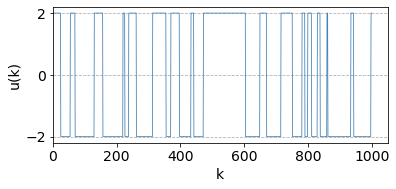

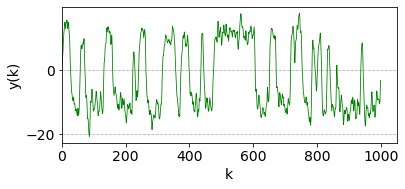

In [2]:
# read fired heater identification test data and plot
data = np.loadtxt('IndustrialFiredHeater_SISO.csv', delimiter=',')
FG = data[:,0, None]
TO = data[:,1, None]

# plots
plt.figure(figsize=(6,2.5)), plt.plot(FG, 'steelblue', linewidth=0.8)
plt.ylabel('u(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5)), plt.plot(TO, 'g', linewidth=0.8)
plt.ylabel('y(k)'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [3]:
# center data before model fitting
u_scaler = StandardScaler(with_std=False) 
FG_centered = u_scaler.fit_transform(FG) 

y_scaler = StandardScaler(with_std=False) 
TO_centered = y_scaler.fit_transform(TO) 

In [4]:
# fit ARX model using AIC 
ARXmodel = SysID(TO_centered, FG_centered, 'ARX', IC='AIC', na_ord=[1,20], nb_ord=[1,20], delays=[0,5])
print(ARXmodel.G)

suggested orders are: Na= 4 ; Nb= 3 Delay:  0

       0.8405 z^3 - 0.1983 z^2 + 0.1147 z
------------------------------------------------
z^4 - 1.541 z^3 + 0.9914 z^2 - 0.4023 z + 0.0877

dt = 1.0



Note that SIPPY and the Control packages use the symbol z to represent the (forward) shift operator. In our book, we use the symbol q and represent the transfer operators in terms of backward shift operator.

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         Residual analysis
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

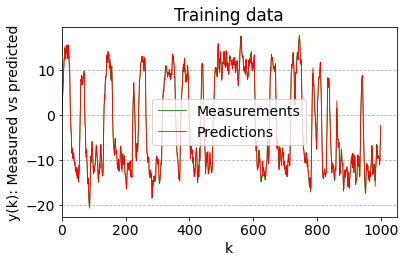

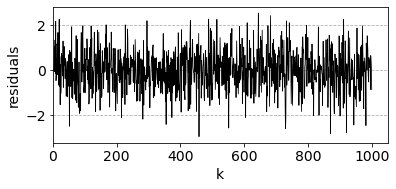

In [6]:
# get model predictions and residuals on training dataset
TO_predicted_centered = ARXmodel.Yid
TO_predicted = np.transpose(y_scaler.inverse_transform(TO_predicted_centered))
residuals = TO - TO_predicted

plt.figure(figsize=(6,3.5)), plt.plot(TO, 'g', linewidth=0.8, label='Measurements'), plt.plot(TO_predicted, 'r', linewidth=0.8, label='Predictions')
plt.title('Training data'), plt.ylabel('y(k): Measured vs predicted'), plt.xlabel('k'), plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5))
plt.plot(residuals, 'black', linewidth=0.8)
plt.ylabel('residuals'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

<Figure size 432x288 with 0 Axes>

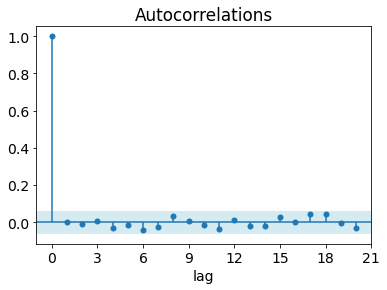

In [7]:
# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.ticker import MaxNLocator

conf_int = 1.96/np.sqrt(len(residuals))

plt.figure()
plot_acf(residuals, lags= 20, alpha=None, title='')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # integer xtick labels
plt.xlabel('lag'), plt.title('Autocorrelations')
plt.show()

In [8]:
# CCF b/w residual and input sequences
ccf_vals = ccf(residuals, FG, adjusted=False) # ccf for lag >= 0
ccf_vals = ccf_vals[:21] # ccf for lag 0 to 20

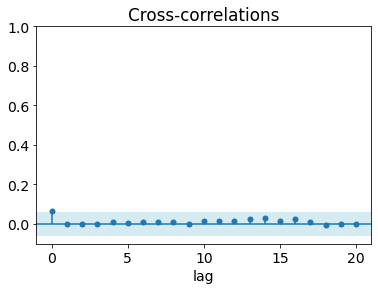

In [9]:
# generate CCF plot
lags = np.arange(0,21)

plt.figure(figsize=(6,4))
plt.vlines(lags, [0], ccf_vals)
plt.axhline(0, 0, lags[-1])
plt.plot(lags, ccf_vals, marker='o', markersize=5, linestyle='None')
plt.gca().axhspan(-conf_int, conf_int, facecolor='lightblue', alpha=0.5) # shaded confidence interval
plt.xlabel('lag'), plt.title('Cross-correlations')
plt.ylim(-0.1, 1)
plt.show()

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                Compare step responses: Model vs Process
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

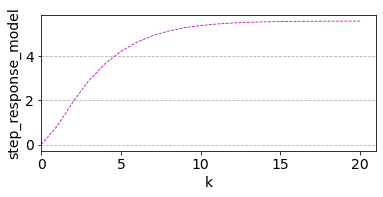

In [11]:
# generate step response of ARX model
step_response_model, _ = control.matlab.step(ARXmodel.G, T=21)

plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8)
plt.ylabel('step_response_model'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

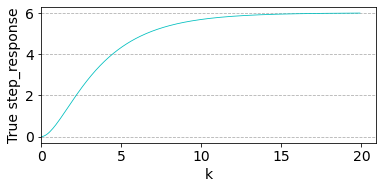

In [12]:
# generate step response of original process
# define the original process
s = control.matlab.tf('s')
sys_G  = 6/(3*s**2 + 4*s + 1)

# get step response
step_response_process, T = control.matlab.step(sys_G, T=20)

plt.figure(figsize=(6,2.5))
plt.plot(T, step_response_process, 'c', linewidth=0.8)
plt.ylabel('True step_response'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

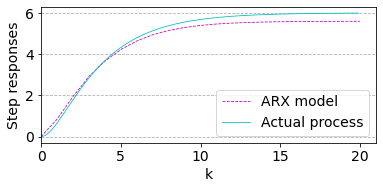

In [13]:
# overlay the step responses
plt.figure(figsize=(6,2.5))
plt.plot(step_response_model, 'm--', linewidth=0.8, label="ARX model")
plt.plot(T, step_response_process, 'c', linewidth=0.8, label="Actual process")
plt.ylabel('Step responses'), plt.xlabel('k'), plt.xlim(0)
plt.legend()
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [14]:
#%% %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
## Check m-step ahead predictions and simulation responses on validation dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

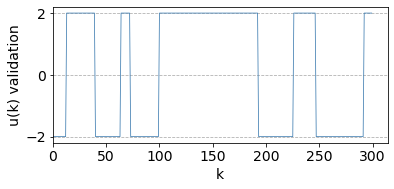

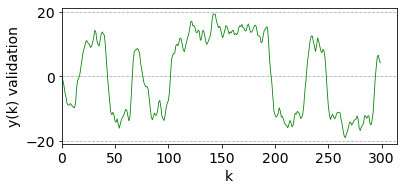

In [15]:
# read fired heater validation data and plot
data_val = np.loadtxt('IndustrialFiredHeater_SISO_Validation.csv', delimiter=',')
FG_val, TO_val = data_val[:,0, None], data_val[:,1, None]

# plots
plt.figure(figsize=(6,2.5))
plt.plot(FG_val, 'steelblue', linewidth=0.8)
plt.ylabel('u(k) validation'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')

plt.figure(figsize=(6,2.5))
plt.plot(TO_val, 'g', linewidth=0.8)
plt.ylabel('y(k) validation'), plt.xlabel('k'), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()

In [16]:
# center validation data
FG_val_centered, TO_val_centered = u_scaler.fit_transform(FG_val), y_scaler.fit_transform(TO_val)

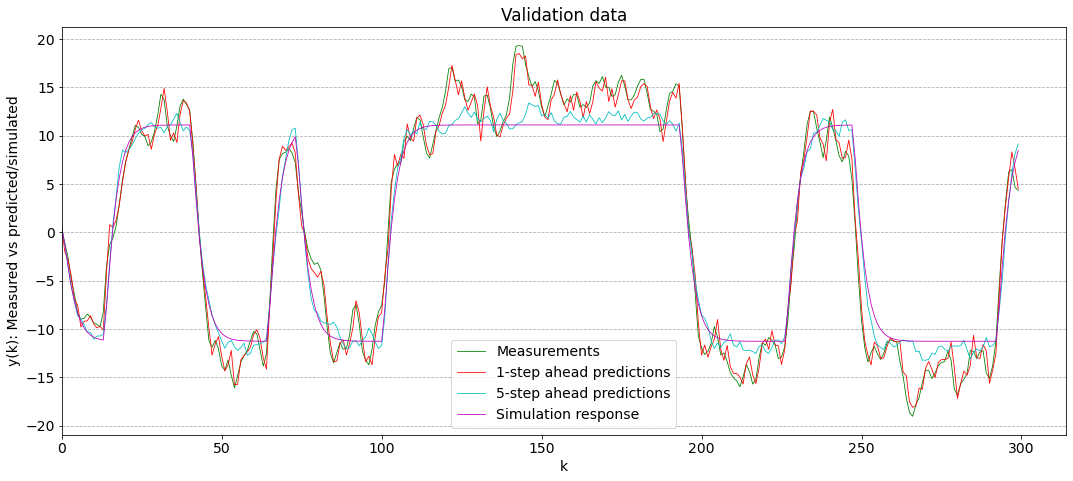

In [17]:
# get model's 1-step ahead and 5-step ahead predictions, and simulation responses on validation dataset
from sippy import functionset as fset

TO_val_predicted_1step_centered = np.transpose(fset.validation(ARXmodel, FG_val_centered, TO_val_centered, np.linspace(0,299,300), k=1))
TO_val_predicted_5step_centered = np.transpose(fset.validation(ARXmodel, FG_val_centered, TO_val_centered, np.linspace(0,299,300), k=5))
TO_val_simulated_centered, _, _ = control.matlab.lsim(ARXmodel.G, FG_val_centered[:,0], np.linspace(0,299,300))

TO_val_predicted_1step = y_scaler.inverse_transform(TO_val_predicted_1step_centered)
TO_val_predicted_5step = y_scaler.inverse_transform(TO_val_predicted_5step_centered)
TO_val_simulated = y_scaler.inverse_transform(TO_val_simulated_centered)

plt.figure(figsize=(18,7.5))
plt.plot(TO_val, 'g', linewidth=0.8, label='Measurements')
plt.plot(TO_val_predicted_1step, 'r', linewidth=0.8, label='1-step ahead predictions')
plt.plot(TO_val_predicted_5step, 'c', linewidth=0.8, label='5-step ahead predictions')
plt.plot(TO_val_simulated, 'm', linewidth=0.8, label='Simulation response')
plt.title('Validation data')
plt.ylabel('y(k): Measured vs predicted/simulated'), plt.xlabel('k')
plt.legend(), plt.xlim(0)
plt.grid(which='both', axis='y', linestyle='--')
plt.show()